# Winter is coming!

<img src="https://pyxis.nymag.com/v1/imgs/028/c95/9998bd19a44092f589f7cf53281bc738bf-28-got-questions.2x.rhorizontal.w700.jpg" style="height:300px" />

In this assignment, we will learn to work with **plotting relational data** in a network representation. We will use a dataset of relationships in the books "A song of ice and fire", which were the source material for the famous television series Game of Thrones.

What are relational data? This term warrants a short explanation.

In most data visualization use cases, you might use a research dataset that is composed of individual observations, which are often collected on the rows of a dataframe. Each of these observations has a number of features (variables), which tend to be collected on the columns of a dataframe. This is a common data organization structure for experimental research, because we tend to repeat experiments many times (= observations) to get a better idea of the underlying process we are trying to study. For instance, you might shoot photons at a nanomaterial and record the result a hundred times, or you might ask a hundred human participants to run a mile and record their blood oxygen levels and heart rate. You are curious about what is shared between all observations, such as the mean or the distribution of the data.

Some research, however, uses different kinds or organizations of data that don't always neatly fit into this mold of observations, features, and shared properties. One example is text data: if you analyze old books you might be dealing with plain text files instead of numerical data tables. Another example is **relational data**, the topic of this assignment. When using relational data, we aren't interested in central tendencies shared between all observations but rather in the **patterns of relations between data points**. If we are interested in armed conflict between countries, for instance, we might not care about how many conflicts a country has on average (central tendency shared between observations) but rather in groups of countries that show the same patterns of conflicts with other countries. This type of data and research question may be best served by representing the data not in an observation-feature dataframe but in an **adjacency matrix**, in which the rows and the columns contain the same items (e.g. countries) and each cell describes something about the relation between those items (e.g. the number of conflicts between a given pair of countries). When visualizing such data, it may be better to show not a plot that emphasizes number values on two orthogonal axes, but a plot that emphasizes relationships between items, such as a **network diagram** or **graph**. A network diagram consists of **nodes** (objects/items) that are connected with **edges** (lines). One advantage of taking this approach is that a ton of interesting maths has been developed that helps us describe and interrogate networks of data. We will catch a glimpse of this (basic) mathematics and visualization in this assignment.

For this assignment you will need to install the following packages (in addition to the default packages described in the class preparation):
* Pyvis
* Networkx
* Seaborn

In [38]:
# # If you are unsure how to install packages with pip in the command line, just uncomment and run this code:
# !pip install pyvis
# !pip install networkx
# !pip install seaborn

Let's go!

## Load basic packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy, os, pyvis, networkx

/var/folders/1_/lcw4zvln3rd_5hb93nn0kqw00000gn/T/ipykernel_76075/3690191198.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Load data

The data for this assignment consist of relationships between characters in the books "A song of ice and fire" book 1 and book 5. We will look at similarities and changes in relationships between these two books (needless to say a lof of stuff happens in between...). For brevity we will call the data set "GoT" after Game of Thrones.

In [2]:
project_dir = os.path.realpath('..') # First we set the project_dir path so python can easily navigate to files and folders we need

In [3]:
GoT_network_book1 = pd.read_csv(project_dir+'/Data/2.GoT/GoT_social-network_book1.csv')
GoT_network_book5 = pd.read_csv(project_dir+'/Data/2.GoT/GoT_social-network_book5.csv')
print(GoT_network_book1.shape)
GoT_network_book1.head()

(684, 5)


,Source,Target,Type,weight,book
0,Addam-Marbrand,Jaime-Lannister,Undirected,3,1
1,Addam-Marbrand,Tywin-Lannister,Undirected,6,1
2,Aegon-I-Targaryen,Daenerys-Targaryen,Undirected,5,1
3,Aegon-I-Targaryen,Eddard-Stark,Undirected,4,1
4,Aemon-Targaryen-(Maester-Aemon),Alliser-Thorne,Undirected,4,1


If we want to know the number of characters in book 1, we can't just look at the shape of the dataframe because each character may have multiple relationships with others. Instead, count the nr of characters as follows:

In [5]:
# How many characters in book 1?
len(np.sort(np.unique(GoT_network_book1['Source'].unique().tolist() + GoT_network_book1['Target'].unique().tolist())))

187

## Some notes on the data type

As you can see, this type of data is different from what we usually get. Instead of individual observations, we have a list of 'source' nodes and 'target' nodes with a 'weight' assigned to their relationship. Every two characters have an entry in this list if their names appear **within 10 words of one another** in the book text. The weight indicates the **number of times** this happens. So Addam Marbrand and Jamie Lannister co-occur (within 10 words) 3 times in book 1.

Since this is relational data, there are some peculiarities to how the data are organized. The first thing to note is that each relationship is only present in the table once, so for instance there is no row where Tywin Lannister is the source and Addam Marbrand is the target. Since the relationships have no hierarchy or direction (value in the "type" column = undirected), this observation would be redundant with what we already have on row 1, and so the redundancy is left out: the names are sorted alphabetically and only the first one of each pair is listed as source. For instance, where Tywin Lannister is the source, only two entries remain, in each of which the target has a name that occurs alphabetically after Tywin. This means that the table in principle could be organized differently (e.g. reverse-alphabetically), which would yield totally different rows but **the relational data would be the same**. This redundancy is a key property of relational data.

In [6]:
GoT_network_book1.loc[GoT_network_book1['Source']=='Tywin-Lannister']

,Source,Target,Type,weight,book
681,Tywin-Lannister,Varys,Undirected,4,1
682,Tywin-Lannister,Walder-Frey,Undirected,8,1


As mentioned above, relational data can also be represented in **adjacency matrix** form, where each item (in this case a source/target character from GoT) is on both the rows and the columns. This kind of table has higher redundancy because by definition both "directions" of an undirected pair are represented, e.g. there is a value for (Addam Marbrand, Tywin Lannister) and for (Tywin Lannister, Addam Marbrand). In addition, an adjacency matrix has a diagonal where each item is related to itself, such as (Addam Marbrand, Addam Marbrand), which is meaningless and therefore contains zeros or 'nan' values (not a number). To achieve adjancency matrix form, we can use the 'pivot_table' method from the Pandas package and assign the Source column to the rows of the new dataframe (the adjancency matrix) and the Target column to the columns of the new dataframe. But first we need to add the required redundancy back in by including both "directions" of each relationship. This is achieved below:

In [7]:
redundant_data = GoT_network_book1.copy()
redundant_data.rename(columns = {'Source':'Target','Target':'Source'},inplace = True)
redundant_data = GoT_network_book1.merge(redundant_data, 'outer', on = ['Source','Target','book','Type','weight'])
print(redundant_data.shape)

(1368, 5)


Then we pivot the contents of the dataframe:

In [8]:
relationships_square_book1 = redundant_data.pivot_table(index = 'Source', columns = 'Target', values = 'weight', fill_value = 0).astype(int)
relationships_square_book1.shape

(187, 187)

The shape of the relationship matrix is 187x187, which makes sense given that there are 187 unique characters.

Peek at a segment of this big adjacency matrix:

In [9]:
relationships_square_book1.iloc[50:60,50:60]

Target,Galbart-Glover,Gared,Gendry,Gerold-Hightower,Gregor-Clegane,Grenn,Gunthor-son-of-Gurn,Haggo,Halder,Hali
Source,,,,,,,,,,
Galbart-Glover,0,0,0,0,0,0,0,0,0,0
Gared,0,0,0,0,0,0,0,0,0,0
Gendry,0,0,0,0,0,0,0,0,0,0
Gerold-Hightower,0,0,0,0,0,0,0,0,0,0
Gregor-Clegane,0,0,0,0,0,0,0,0,0,0
Grenn,0,0,0,0,0,0,0,0,6,0
Gunthor-son-of-Gurn,0,0,0,0,0,0,0,0,0,0
Haggo,0,0,0,0,0,0,0,0,0,0
Halder,0,0,0,0,0,6,0,0,0,0


Do the same for book 5:

In [10]:
redundant_data = GoT_network_book5.copy()
redundant_data.rename(columns = {'Source':'Target','Target':'Source'},inplace = True)
redundant_data = GoT_network_book5.merge(redundant_data, 'outer', on = ['Source','Target','book','Type','weight'])
relationships_square_book5 = redundant_data.pivot_table(index = 'Source', columns = 'Target', values = 'weight', fill_value = 0).astype(int)
relationships_square_book5.shape

(317, 317)

# Exercise 1: Simplifying the data

As you can see above, book 1 already contains 187 unique characters and book 5 contains 317. This high number makes it difficult to explore the relationships easily, so we will 'prune' the number of characters a bit. Consider that many characters in the book play only a small role -- how can we eliminate these minor characters? Implement your answer.

Solution: let's keep only major characters, defined as **characters who interact with at least 6 other characters**. To do so, let's determine how many relationships (i.e. connections with a value of 1 or higher) each character has:

In [11]:
major_characters_book1 = (
    (relationships_square_book1 > 0)
    .sum()
    .pipe(pd.DataFrame, columns = ['Nr_of_relationships'])
    .sort_values(by = 'Nr_of_relationships', ascending = False)
    .query('Nr_of_relationships >= 10')
)
major_character_names_book1 = major_characters_book1.index.tolist()
len(major_character_names_book1)

40

In [12]:
major_characters_book5 = (
    (relationships_square_book5 > 0)
    .sum()
    .pipe(pd.DataFrame, columns = ['Nr_of_relationships'])
    .sort_values(by = 'Nr_of_relationships', ascending = False)
    .query('Nr_of_relationships >= 10')
)
major_character_names_book5 = major_characters_book5.index.tolist()
len(major_character_names_book5)

29

What's interesting about this result?
Answer: while book 5 has many more characters (317) than book 1 (187), the number of major characters (who interact with 10 or more others) is actually much smaller (29 vs 40).

Now we can select from the dataframe only the rows that contain these characters:

In [13]:
major_character_relationships_book1 = relationships_square_book1[major_character_names_book1].loc[major_character_names_book1]
major_character_relationships_book5 = relationships_square_book5[major_character_names_book5].loc[major_character_names_book5]

This yields smaller, more manageable adjacency matrices.

# Exercise 2: Plotting the data in a heatmap

A simple way to show an adjacency matrix is with a **heatmap**. Use the seaborn.heatmap function to plot the adjacency matrices from book 1 and book 5 side-by-side in a figure. Can you tell which pairs of characters have the strongest relationship (as measured by co-occurrence in the text)?

Solution:

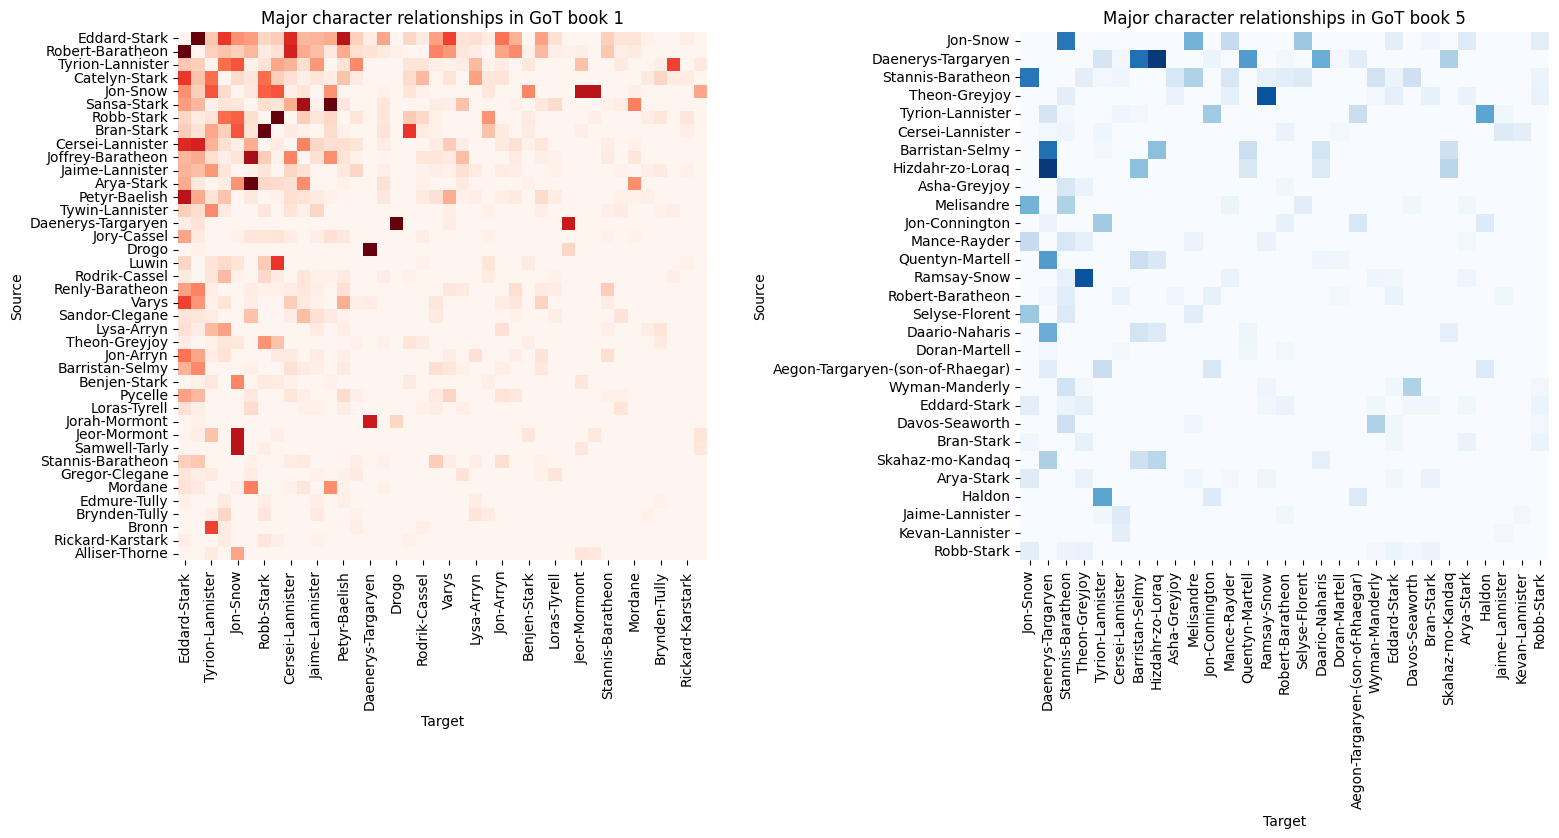

In [15]:
fig,ax = plt.subplots(nrows=1, ncols = 2, figsize = [16,8])
sns.heatmap(major_character_relationships_book1, ax = ax[0], vmax = 100, cmap = 'Reds', square = True, cbar = False) # Set max value of the color scheme to 10, otherwise it is difficult to see low values.
sns.heatmap(major_character_relationships_book5, ax = ax[1], vmax = 100, cmap = 'Blues', square = True, cbar = False) # Set max value of the color scheme to 10, otherwise it is difficult to see low values.
ax[0].set(title = 'Major character relationships in GoT book 1');
ax[1].set(title = 'Major character relationships in GoT book 5');
plt.tight_layout()
fig.savefig(project_dir + '/Results/2.GoT/1.Major_characters_relationships_heatmap.png', transparent = True, bbox_inches = 'tight')
fig.savefig(project_dir + '/Results/2.GoT/1.Major_characters_relationships_heatmap.pdf', transparent = True, bbox_inches = 'tight')

Strongest relationships in book 1 are e.g. (Eddard Stark, Robert Baratheon) and (Daenerys Targaryen, Drogo).
In book 5 they include (Jon Snow, Stannis Baratheon) and (Daenerys Targaryen, Hizdahr zo Loraq).

## Exercise 3: Visualizing the network

Use the networkx package to visualize the relationships from books 1 and 5 in network form.
* Try to identify clusters of relationships: friend groups. Which clusters can you find in book 1? Which in book 5?
* Bonus question. Two of the main characters from GoT are Jon Snow and Daenerys Targaryen. Between these two characters, whose relationship network changed the most between book 1 and 5? You might need to go back to the original dataframes for this one...

Solution:

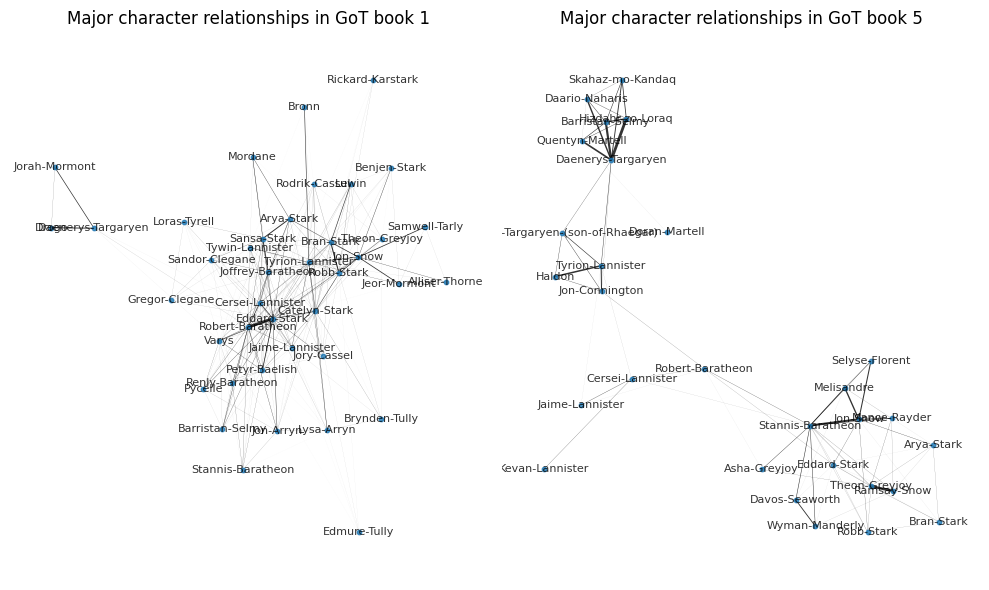

In [16]:
fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = [10,6])

# Book 1:
book1_nx = networkx.from_pandas_adjacency(major_character_relationships_book1)
weights_book1 = np.array([major_character_relationships_book1[edge[0]][edge[1]] for edge in book1_nx.edges()])
weights_book1 = 2 * (weights_book1 - weights_book1.min()) / (weights_book1.max() - weights_book1.min())
networkx.draw(book1_nx, ax=axes[0], node_size = 10, with_labels = True, font_size = 8, alpha = .8, width = weights_book1)

# Book 5:
book5_nx = networkx.from_pandas_adjacency(major_character_relationships_book5)
weights_book5 = np.array([major_character_relationships_book5[edge[0]][edge[1]] for edge in book5_nx.edges()])
weights_book5 = 2 * (weights_book5 - weights_book5.min()) / (weights_book5.max() - weights_book5.min())
networkx.draw(book5_nx, ax=axes[1], node_size = 10, with_labels = True, font_size = 8, alpha = .8, width = weights_book5)

# Design
axes[0].set(title = 'Major character relationships in GoT book 1');
axes[1].set(title = 'Major character relationships in GoT book 5');
plt.tight_layout()

# Save
fig.savefig(project_dir + '/Results/2.GoT/2.Major_characters_relationships_network.png', transparent = True, bbox_inches = 'tight')
fig.savefig(project_dir + '/Results/2.GoT/2.Major_characters_relationships_network.pdf', transparent = True, bbox_inches = 'tight')

Clusters in book 1 include the King's Landing group (Lannisters/Starks/Baratheons), the watchers on the Wall (Snow/Mormont/Tarly), and the Dothraki group (Daenerys/Drogo/Jorah).
Clusters in book 5 include Danaerys and her clique, Stannis/Melisandre/Jon Snow, etc.

These two graphs represent the relationship networks between the major characters of book 1 and book 5. Each time you generate the plot, a new graph organization is generated. This needs to happen because there is no perfect way to display a graph. The closeness of two characters in the graph reflects their relationships in the dataframe, but in a 2-dimensional plane (the graph) all the characters cannot be shown with perfect fidelity of their distances. Instead, the user can indicate where characters should appear on the graph, or the networkx package generates a spatial organization for you. If you want to adjust the graph interactively, use the pyvis package instead, as shown below. This code produces two html files, 'book1.html' and 'book5.html', which you can open in your browser. You will see an interactive graph that you can move around with your mouse and a window of variables with which you can adjust the graph's organization and behavior in space.

In [20]:
from pyvis.network import Network

book1_net = Network(notebook = True, height = '900px', width = '75%')
book1_net.from_nx(book1_nx)
book1_net.toggle_physics(True)
book1_net.show_buttons(filter_=['physics'])
book1_net.show(name = 'Book1.html')
book1_net.save_graph(project_dir + '/Results/2.GoT/3.Major_characters_relationships_network_interactive_book1.html')

book5_net = Network(notebook = True, height = '900px', width = '75%')
book5_net.from_nx(book5_nx)
book5_net.toggle_physics(True)
book5_net.show_buttons(filter_=['physics'])
book5_net.show(name = 'Book5.html')
book5_net.save_graph(project_dir + '/Results/2.GoT/3.Major_characters_relationships_network_interactive_book5.html')

Book1.html
Book5.html
